# Fishery Subsidies
Government fishing subsidies, disaggregated by category (though not fully by type), for all available countries/territories.  

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.  

_Author: Peter Kerins_  
_Created: 17 Aug 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Horizontal bar chart
- Categories

## Data
Underlying dataset: [ocn.022 Fisheries Subsidies](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_022_rw0_fisheries_subsidies_edit)
Widget data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (master table for all territory-based widgets on Ocean Watch)  

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 400
widget_height = 300

# Widget

## Demo Query
`gid_0 = <territory>` used as stand-in for parameterization
```sql
SELECT gid_0, name_0, variable, date, value
FROM "wri-rw".ow_widget_territory
WHERE widget = 'fisheries_subsidies' 
AND gid_0 = 'BRA'
```

## Parameterized Query
```sql
SELECT territory.gid_0, territory.name_0, variable, date, value
FROM ow_widget_territory AS territory
LEFT OUTER JOIN gadm36_0 AS gadm ON territory.gid_0 = gadm.gid_0
WHERE territory.widget = 'fisheries_subsidies' 
AND gadm.{{geostore_env}}='{{geostore_id}}'
```

## Specification
Vega code presumes RW-style `config` element present

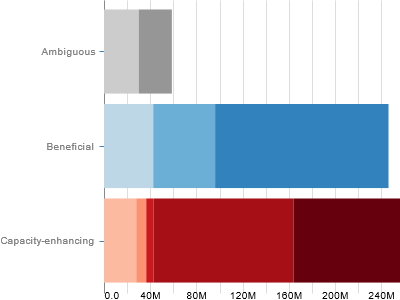

In [4]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Fishing subsidies for a given country, disaggregated by category, then type",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, name_0, variable, date, value FROM ow_widget_territory WHERE widget = 'fisheries_subsidies' AND gid_0 = 'BRA'",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"date": "utc:'%Y-%m-%d %H:%M:%S'"}
      },
      "transform": [
        {
          "type": "formula",
          "expr": "slice(datum.variable, 0, indexof(datum.variable,','))",
          "as": "category"
        },
        {
          "type": "formula",
          "expr": "slice(datum.variable, indexof(datum.variable,',')+2)",
          "as": "type"
        },
        {
          "type": "collect",
          "sort": {
            "field": ["category","type"],
            "order": ["ascending", "ascending"]
          }
        },
        {
          "type": "stack",
          "groupby": ["category"],
          "field": "value",
          "sort": {
            "field": ["type"],
            "order": ["ascending"]
          },
          "as": ["x0", "x1"]
        }
      ]
    },
    {
      "name": "sums",
      "source": "table",
      "transform": [
        {
          "type": "aggregate",
          "fields": ["value"],
          "groupby": ["category"],
          "ops": ["sum"],
          "as": ["sum"]
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "xscale",
      "type": "linear",
      "domain": {"data": "table", "fields": ["x0","x1"]},
      "range": "width",
      "padding": 0
    },
    {
      "name": "yscale",
      "type": "band",
      "domain": {"data": "table", "field": "category"},
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "colorscale",
      "type": "ordinal",
      "domain": [
        "Fisher assistance",
        "Rural fisher communities",
        "Vessel buyback",
        "Fisheries management",
        "Fishery R&D",
        "MPAs",
        "Boat construction & renovation",
        "Fisheries development projects",
        "Fishing access",
        "Fishing port development",
        "Fuel subsidies",
        "Market & storage infrastructure",
        "Tax exemption"
      ],
      "range": [
        "#cccccc",
        "#969696",
        "#636363",
        "#bdd7e7",
        "#6baed6",
        "#3182bd",
        "#fcbba1",
        "#fc9272",
        "#fb6a4a",
        "#ef3b2c",
        "#cb181d",
        "#a50f15",
        "#67000d"
      ]
    },
    {
      "name": "sumsscale",
      "type": "ordinal",
      "domain": {"data": "sums", "field": "category"},
      "range": {"data": "sums", "field": "sum"}
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "xscale",
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "domain": false,
      "ticks": false,
      "grid": true,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "format": ".2s"
    },
    {
      "orient": "left",
      "scale": "yscale",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": false,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "encode": {
        "ticks": {
          "update": {
            "stroke": {"value": "steelblue"}
          }
        },
        "labels": {
          "interactive": true,
          "enter": {
            "tooltip": {
              "signal": "{'Expenditure':format(scale('sumsscale', datum.label),'$,d')}"
            }
          },
          "update": {
            "fill": {"value": "grey"}
          },
          "hover": {
            "fill": {"value": "firebrick"}
          }
        }
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "x0"},
          "x2": {"scale": "xscale", "field": "x1"},
          "height": {"scale": "yscale", "band": 1, "offset": -1},
          "y": {"scale": "yscale", "field": "category"},
          "fill": {"scale": "colorscale", "field": "type"},
          "stroke": {"value": "black"},
          "strokeWidth": {"value": 0.5},
          "tooltip": {
            "signal": "{'Category':datum.category, 'Type': datum.type, 'Value':format(datum.value,'$,d')}"
          }
        },
        "update": {
          "fillOpacity": {"value": 1},
          "strokeOpacity": {"value": 0}
        },
        "hover": {
          "fillOpacity": {"value": 0.5},
          "strokeOpacity": {"value": 1}
        }
      }
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# RW API

Parameterized widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

[ocn.022.rw0 Fishing Subsidies]() ([Admin](https://resourcewatch.org/admin/data/datasets/42859b52-31f2-419c-ac14-8b0cbd6bbb6f/edit))  
`42859b52-31f2-419c-ac14-8b0cbd6bbb6f`  
[Dataset](https://api.resourcewatch.org/v1/dataset/42859b52-31f2-419c-ac14-8b0cbd6bbb6f/), [Widgets](https://api.resourcewatch.org/v1/dataset/42859b52-31f2-419c-ac14-8b0cbd6bbb6f/widget)

In [5]:
dataset_id = '42859b52-31f2-419c-ac14-8b0cbd6bbb6f'
name = 'Expenditure on Fishing Subsidies'
description = 'Fishing subsidies in US dollars, grouped by category and disaggregated by specific type'

- [Country](https://api.resourcewatch.org/v1/widget/2cb5af4f-2bfc-49f3-9f99-ac415e98c7db?env=production) `2cb5af4f-2bfc-49f3-9f99-ac415e98c7db`  